# Multi-scale Clustering Analysis of Wildfire Hazards and Machine Learning-based Burn Severity Prediction
## Sampling method0: Patch based averages

## Required libraries and dependencies

In [3]:
import rasterio, os, glob, warnings, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.inspection import permutation_importance 

from sampling import *
from utils import *

warnings.filterwarnings("ignore")
plt.rcParams["figure.autolayout"] = True

## Input Paths and Data
Change data paths to local

In [4]:
# Input image paths
basepath = 'D:\GitHub\ExplainableFire\datasets'
os.chdir(basepath)

img_train = sorted(glob.glob('s2*.tif'))
dem_train = sorted(glob.glob('dem*.tif'))
slope_train = sorted(glob.glob('slope*.tif'))
aoi_train = sorted(glob.glob('fire*.tif'))
lulc_train = sorted(glob.glob('lulc*.tif'))

# Weather data
rmin_train = sorted(glob.glob('rmin*.tif'))
rmax_train = sorted(glob.glob('rmax*.tif'))
tmmn_train = sorted(glob.glob('tmmn*.tif'))
tmmx_train = sorted(glob.glob('tmmx*.tif'))
vs_train = sorted(glob.glob('vs*.tif'))

In [5]:
# Input Parameters
number_of_sample_points = 10000 # This selects the number of samples from each burn severity class
random_state = 42 # Random seed number to keep consistent
input_bands = 5 # Number of features in the training dataset (10) and with weather (10 + 5)

patch_size = 10 # Patch size (Order of neighboring pixels - eg. 10 = 10x10 patch)

## Sampling
- Total samples: 10,000 samples (points at 10m resolution) with 2,500 samples for each burn severity class
- Split: Frequency relative to total pixel count for each burn severity class
- Method: Random sampling 

In [6]:
# Create input dataset stack
img_train, dem_train, slope_train, lulc_train, aoi_train = paths(basepath)

img_size_list = []

for i in range(len(img_train)):
    img, img_meta = open_multiband(img_train[i])    
    img_size_list.append(img.shape[0]*img.shape[1])    
    
del img_meta 

img_size_df = pd.DataFrame(columns = ['size', 'weight','weighted_pix', 'low','low-med','med-high','high'])
img_size_df.size = img_size_list
# img_size_df.reset_index(level=0, inplace=True)

# Random sampling for each image (based on AOI size and burn severity class frequency)
for i in range(len(img_size_df)):
    img_size_df['weight'][i] = img_size_df['size'][i]/img_size_df['size'].sum()
    img_size_df['weighted_pix'][i] = img_size_df['weight'][i]*100

    aoi, aoi_meta = open_data(aoi_train[i])
    aoi[aoi > 4] = 0 # Set nodata values to 0 or NaN
    
    img_size_df['low'][i] = len(aoi[aoi==1])
    img_size_df['low-med'][i] = len(aoi[aoi==2])
    img_size_df['med-high'][i] = len(aoi[aoi==3])
    img_size_df['high'][i] = len(aoi[aoi==4])
    
del aoi_meta

burn_sev_df = img_size_df.copy().drop(columns = ['size','weight','weighted_pix'])

for i in range(len(img_size_df)):
    burn_sev_df['low'][i] = img_size_df['low'][i]/img_size_df['low'].sum()*number_of_sample_points
    burn_sev_df['low-med'][i] = img_size_df['low-med'][i]/img_size_df['low-med'].sum()*number_of_sample_points
    burn_sev_df['med-high'][i] = img_size_df['med-high'][i]/img_size_df['med-high'].sum()*number_of_sample_points
    burn_sev_df['high'][i] = img_size_df['high'][i]/img_size_df['high'].sum()*number_of_sample_points

# Processing methods (Choose ONE)
- Method 0 : Patch based averages --> 18 features
- Method 1 : Random sampling --> 10 features
- Method 2 : Fixed sampling --> 10 features
- Method 3 : Random + Fixed sampling using dataset split in chronological order
- Method 4 : Patch sampling --> 10 features (for deep learning : creates 4d tensors)
** eg. (# samples, patch_x, patch_y, # features)

## Method 0 (Patch-based averages)
- 18 features

In [7]:
# Set AOI sample counts
df1 = burn_sev_df.round(0).astype(int) # Take integer values for sampling count

feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect', 'LULC',
                'Blue_m','Green_m','Red_m','NIR_m','NDVI_m','SAVI_m','DEM_m','Slope_m']

# # Set empty placeholders for training dataset
low_train = pd.DataFrame(columns = ['c1','c2','features'])
mlow_train = pd.DataFrame(columns = ['c1','c2','features'])
mhigh_train = pd.DataFrame(columns = ['c1','c2','features'])
high_train = pd.DataFrame(columns = ['c1','c2','features'])

# Create training datasets
for i in range(len(df1)): # df1 = Dataframe with burn severity AOIs
    img_stack, _ = input_data(method=1, basepath=basepath, patch_size=patch_size, i=i)
    img_padded = input_data_patches(method=4, basepath=basepath, patch_size=patch_size, i=i)
 
    # Find required number of samples for each burn severity class
    aoi_t, aoi_low, aoi_mlow, aoi_mhigh, aoi_high = read_aoi(aoi_train[i])
    
    def random_patch_sample(sample_dataset, sev_dataset, clss, sev_num):
        # Number of samples to be selected for random sampling
        sample_count = sample_dataset[clss][i]
        # Random sampling for each burn severity class
        sev_df = mean_sampling(img_stack, img_padded, sev_dataset, sev_num, sample_count, patch_size, random_state)
        return sev_df

    # Extract random samples from each burn severity class
    low_df2 = random_patch_sample(df1, aoi_low, 'low', 1)
    mlow_df2 = random_patch_sample(df1, aoi_mlow, 'low-med', 2)
    mhigh_df2 = random_patch_sample(df1, aoi_mhigh, 'med-high', 3)
    high_df2 = random_patch_sample(df1, aoi_high, 'high', 4)
        
     # Add to training datasets
    low_train=low_train.append(low_df2)
    mlow_train=mlow_train.append(mlow_df2)
    mhigh_train=mhigh_train.append(mhigh_df2)
    high_train=high_train.append(high_df2)

In [8]:
# Create training datasets for each burn severity
def create_datasets(train_set,sev):
    train = train_set.reset_index(inplace=False, drop=True)
    train_dataset = pd.DataFrame(train["features"].to_list(), 
                                 columns=feature_names)
    return train_dataset

low_train = create_datasets(low_train, 1)
mlow_train = create_datasets(mlow_train, 2)
mhigh_train = create_datasets(mhigh_train, 3)
high_train = create_datasets(high_train, 4)

# If patches produce Nan values
training_dataset = np.vstack((low_train, mlow_train, mhigh_train, high_train))
todrop = [np.argwhere(np.isnan(training_dataset))[i][0] for i in range(len(np.argwhere(np.isnan(training_dataset))))]
training_dataset = pd.DataFrame(training_dataset)
training_dataset=training_dataset.drop(np.unique(todrop))

# Create ground truth for each burn severity
def create_gt(train_set, sev):
    gt_dataset = np.full((train_set.shape[0], 1), sev)
    return gt_dataset

low_gt = create_gt(low_train, 1)
mlow_gt = create_gt(mlow_train, 2)
mhigh_gt = create_gt(mhigh_train, 3)
high_gt = create_gt(high_train, 4)
gt_dataset = np.vstack((low_gt, mlow_gt, mhigh_gt, high_gt))

# If patches produce Nan values
gt_dataset = pd.DataFrame(gt_dataset)
gt_dataset=gt_dataset.drop(np.unique(todrop))

In [9]:
# Holdout sets
X_train, X_test, y_train, y_test = train_test_split(training_dataset, gt_dataset, test_size=0.2, random_state=random_state)
print("Training dataset size: ", len(X_train))
print("Test dataset size: ", len(X_test))

Training dataset size:  31937
Test dataset size:  7985


In [10]:
# Create a Classifier (Random Forest)
clf=RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train,y_train) # Train the model using the training sets y_pred=clf.predict(X_test)
y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cr = classification_report(y_test, y_pred)
print(cr)

Accuracy: 0.6275516593613024
              precision    recall  f1-score   support

           1       0.72      0.69      0.71      2039
           2       0.56      0.54      0.55      1954
           3       0.53      0.49      0.51      1990
           4       0.68      0.78      0.73      2002

    accuracy                           0.63      7985
   macro avg       0.62      0.63      0.62      7985
weighted avg       0.62      0.63      0.62      7985



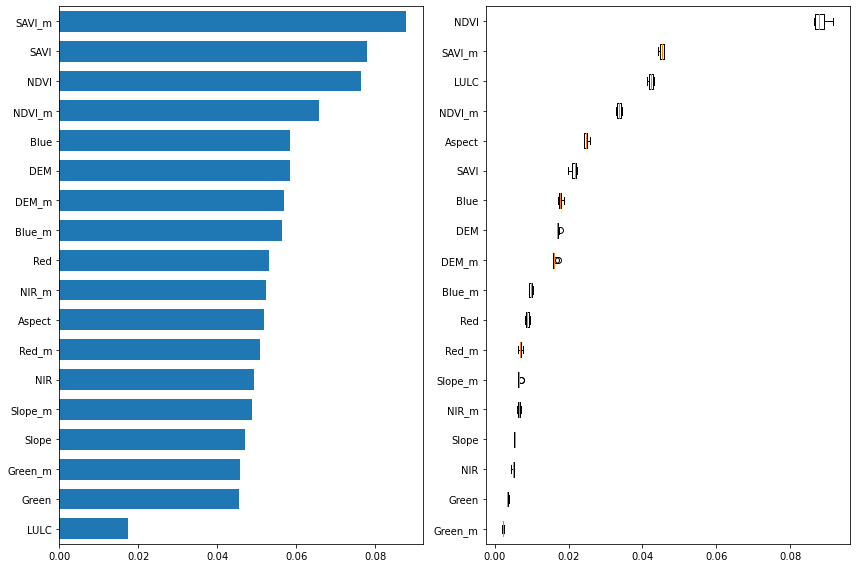

In [11]:
# Feature importance (permutation)
feature_names = ['Blue','Green','Red','NIR','NDVI','SAVI','DEM','Slope','Aspect','LULC',
                'Blue_m','Green_m','Red_m','NIR_m','NDVI_m','SAVI_m','DEM_m','Slope_m']

# feature_names = [f"feature {i+1}" for i in range(training_dataset.shape[1])]

# Combination of MDI and permutation importance (Vertical graphs)
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels([feature_names[i] for i in tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=[feature_names[i] for i in perm_sorted_idx],
)
fig.tight_layout()
plt.show()

## Set of all machine learning algorithms

In [23]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

clf_list = {
    'mlp': MLPClassifier(random_state=random_state, max_iter=1000),
    'gnb': GaussianNB(),
    'ada': AdaBoostClassifier(random_state=random_state),
    'gbc': GradientBoostingClassifier(random_state=random_state),
    'rf':  RandomForestClassifier(n_estimators=100, n_jobs=-1,random_state=random_state)
}
clf_df = []


def ml_classify(clf, clf_name):

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    # Model Accuracy, how often is the classifier correct?
    print(key, "accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    cr = classification_report(y_test, y_pred, output_dict = True)
    df = pd.DataFrame(cr).transpose()
    
    return df


for key, classifier in clf_list.items():
    cr = ml_classify(classifier, key)
#     clf_df.append(key)
    clf_df.append(cr)

mlp accuracy: 0.5939887288666249
gnb accuracy: 0.42341891045710706
ada accuracy: 0.4895428929242329
gbc accuracy: 0.5693174702567314
rf accuracy: 0.6260488415779587


In [24]:
# Save files to folder

# clf_df[0].to_csv ('mlp_fixed.csv', index = False, header=True)
# clf_df[1].to_csv ('gnb_fixed.csv', index = False, header=True)
# clf_df[2].to_csv ('ada_fixed.csv', index = False, header=True)
# clf_df[3].to_csv ('gbc_fixed.csv', index = False, header=True)
# clf_df[4].to_csv ('rf_fixed.csv', index = False, header=True)